Doing our Supply/demand contribution graph properly (Which influenceer has hte most influence?) - November 4,2024 Note

In [5]:
import pandas as pd
import numpy as np
from dotenv import dotenv_values, find_dotenv
import os
import re
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from itertools import islice

config = dotenv_values(find_dotenv())
path_rawdata = os.path.abspath(config["RAWDATA"]) + '/'
path_cleandata = os.path.abspath(config["CLEANDATA"]) + '/'

Matplotlib is building the font cache; this may take a moment.


KeyError: 'RAWDATA'

In [ ]:
shaprio_proucts = pd.read_excel(path_rawdata + 'shaprio_products.xlsx')
gamma = pd.read_excel(path_cleandata + "/gamma.xlsx")
shaprio_proucts['Products'] = shaprio_proucts['Products'].apply(lambda x: re.sub(r'\([^\)]*\d[^\)]*\)', '', x))
shaprio_proucts['Products'] = shaprio_proucts['Products'].str.rstrip()
gamma_shaprio = gamma[gamma["Unnamed: 0"].isin(shaprio_proucts['Products'])]
gamma_shaprio.reset_index(drop=True, inplace=True)
gamma_shaprio

,Unnamed: 0,Row_Sum
0,Accessories and parts,0.312497
1,Air transportation,0.042771
2,"Amusement parks, campgrounds, and related recr...",0.092564
3,Beer,0.442739
4,Bicycles and accessories,0.153906
...,...,...
88,Water supply and sewage maintenance,0.077826
89,Water transportation,0.045388
90,Window coverings,0.125151
91,Wine,0.373515


In [ ]:
CPI = pd.read_excel(path_rawdata + '/Shapiro Inflation Numbers.xlsx', sheet_name="Headline Inflation")
CPI = CPI.rename(columns={CPI.columns[1]: 'Inflation'})

In [ ]:
expenditures = pd.read_excel(path_rawdata + "/BEA Monthly Expenditures.xlsx", header=[0, 1], skiprows=5)
month_mapping = {
    'JAN': '01', 'FEB': '02', 'MAR': '03', 'APR': '04',
    'MAY': '05', 'JUN': '06', 'JUL': '07', 'AUG': '08',
    'SEP': '09', 'OCT': '10', 'NOV': '11', 'DEC': '12'
}
expenditures.columns = [f"{str(col[0])}-{month_mapping.get(str(col[1]).upper(), str(col[1]))}" if col[0] not in [None, 'Unnamed'] else col[1] for col in expenditures.columns]
expenditures = expenditures.drop(expenditures.columns[0], axis=1)
expenditures = expenditures[:-5]
expenditures['Line-Unnamed: 1_level_1'] = expenditures['Line-Unnamed: 1_level_1'].apply(lambda x: re.sub(r'\([^\)]*\d[^\)]*\)', '', x))
expenditures['Line-Unnamed: 1_level_1'] = expenditures['Line-Unnamed: 1_level_1'].str.strip()
expenditures = expenditures[expenditures['Line-Unnamed: 1_level_1'].isin(gamma_shaprio['Unnamed: 0'])]
expenditures = expenditures[~expenditures["Line-Unnamed: 1_level_1"].duplicated(keep='first')]
expenditures.reset_index(inplace=True, drop=True)
expenditures = expenditures.rename(columns={expenditures.columns[0]: 'Products'})
expenditures

,Products,1959-01,1959-02,1959-03,1959-04,1959-05,1959-06,1959-07,1959-08,1959-09,...,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09
0,New light trucks,407,442,475,482,477,470,470,470,463,...,343707,320089,333938,334097,339212,345800,323894,346961,329851,341061
1,Tires,1469,1490,1484,1499,1504,1509,1529,1563,1555,...,52519,52673,52650,53335,52985,53015,53588,53967,54374,54677
2,Accessories and parts,826,838,838,849,854,865,873,898,899,...,71759,71372,71391,72380,72126,72479,71843,72712,72860,73169
3,Furniture,4724,4817,4775,4880,4850,5151,4889,4908,4889,...,159709,161577,156945,155628,156059,156440,159133,160143,159860,159181
4,"Clocks, lamps, lighting fixtures, and other ho...",1173,1182,1172,1162,1207,1229,1197,1207,1229,...,57105,57832,57459,57976,57664,58037,59441,58972,59986,60733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,Domestic services,3550,3576,3602,3625,3651,3680,3707,3736,3771,...,38984,39096,39188,39264,39358,39456,39545,39631,39717,39805
89,"Moving, storage, and freight services",299,305,311,317,323,329,335,341,347,...,21903,21617,21422,21603,21786,21824,21907,21854,21876,21971
90,"Repair of furniture, furnishings, and floor co...",369,372,375,378,384,387,390,390,393,...,2274,2379,2458,2504,2439,2331,2314,2402,2405,2402
91,Repair of household appliances,173,201,229,264,297,282,261,241,219,...,11130,11435,11736,11896,11684,11292,11271,11692,11686,11694


In [ ]:
prices = pd.read_excel(path_rawdata + '/BEA Monthly Prices.xlsx', header=[0, 1], skiprows=5)

prices.columns = [f"{str(col[0])}-{month_mapping.get(str(col[1]).upper(), str(col[1]))}" if col[0] not in [None, 'Unnamed'] else col[1] for col in prices.columns]
prices = prices.drop(prices.columns[0], axis=1)
prices = prices[:-5]
prices['Line-Unnamed: 1_level_1'] = prices['Line-Unnamed: 1_level_1'].apply(lambda x: re.sub(r'\([^\)]*\d[^\)]*\)', '', x))
prices['Line-Unnamed: 1_level_1'] = prices['Line-Unnamed: 1_level_1'].str.strip()
prices = prices[prices['Line-Unnamed: 1_level_1'].isin(gamma_shaprio['Unnamed: 0'])]
prices = prices[~prices["Line-Unnamed: 1_level_1"].duplicated(keep='first')]
prices.reset_index(inplace=True, drop=True)
prices = prices.rename(columns={prices.columns[0]: 'Products'})
prices

,Products,1959-01,1959-02,1959-03,1959-04,1959-05,1959-06,1959-07,1959-08,1959-09,...,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09
0,New light trucks,32.438,32.436,32.559,32.493,32.616,32.678,32.678,32.617,32.744,...,122.337,122.233,122.126,121.921,121.472,120.847,120.714,120.479,120.589,120.773
1,Tires,46.107,46.026,46.019,46.02,45.927,45.94,46.11,41.234,41.405,...,122.59,123.527,123.025,122.676,122.321,123.383,122.986,123.506,123.166,124.484
2,Accessories and parts,27.263,27.204,27.268,27.329,27.337,27.271,26.932,26.734,27.27,...,125.717,127.705,128.368,127,127.938,128.658,128.088,129.247,129.682,130.093
3,Furniture,41.469,41.47,41.568,41.668,41.668,41.77,41.67,41.671,41.67,...,118.827,120.414,119.613,119.92,119.323,118.56,117.551,116.382,115.203,117.114
4,"Clocks, lamps, lighting fixtures, and other ho...",142.904,142.663,142.907,143.208,143.455,143.737,144.266,144.294,144.287,...,96.396,96.834,97.164,96.885,97.798,97.02,97.13,98.721,98.317,97.123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,Domestic services,9.234,9.216,9.205,9.202,9.168,9.346,9.512,9.715,9.772,...,135,137.058,137.752,138.72,136.613,136.104,137.929,138.008,138.082,138.442
89,"Moving, storage, and freight services",11.472,11.618,11.757,11.757,11.44,12.225,11.864,12.192,12.137,...,123.001,121.711,124.188,125.102,127.761,127.768,129.833,130.877,129.78,129.653
90,"Repair of furniture, furnishings, and floor co...",9.071,9.064,9.1,9.104,9.193,9.204,9.22,9.281,9.23,...,156.743,157.721,157.728,160.127,160.824,155.95,158.141,164.304,164.356,162.944
91,Repair of household appliances,6.835,6.909,6.899,6.973,6.975,7.034,7.054,7.083,7.078,...,156.811,157.789,157.796,160.196,160.894,156.017,158.21,164.375,164.427,163.014


In [ ]:
inflation_df = prices.copy()

for index, row in prices.iterrows():
    for col in range(2, len(row)):  
        if col <= 12:
            continue
        else: 
            current_value = prices.iloc[index, col]
            shifted_value = prices.iloc[index, col - 12]
            
            if shifted_value != 0:  # Avoid division by zero
                inflation_df.iloc[index, col] = ((current_value / shifted_value) - 1) * 100
            else:
                inflation_df.iloc[index, col] = np.nan  # Handle division by zero

# inflation_df.set_index(inflation_df.columns[0], inplace=True)
prices.set_index(prices.columns[0], inplace=True)
inflation_df


,Products,1959-01,1959-02,1959-03,1959-04,1959-05,1959-06,1959-07,1959-08,1959-09,...,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09
0,New light trucks,32.438,32.436,32.559,32.493,32.616,32.678,32.678,32.617,32.744,...,1.050675,0.727647,0.440826,-0.00082,-0.248,-0.695192,-0.79307,-0.928393,-1.113599,-1.198482
1,Tires,46.107,46.026,46.019,46.02,45.927,45.94,46.11,41.234,41.405,...,-1.14746,-0.381452,-0.420093,-0.630999,-1.307074,-1.075174,-1.61907,-1.265499,-1.634814,1.550786
2,Accessories and parts,27.263,27.204,27.268,27.329,27.337,27.271,26.932,26.734,27.27,...,-0.796206,-0.607075,1.207859,-1.025593,-1.293832,0.543126,0.532929,3.223359,3.308399,3.532717
3,Furniture,41.469,41.47,41.568,41.668,41.668,41.77,41.67,41.671,41.67,...,-4.253622,-2.931076,-3.734316,-3.834742,-3.82219,-3.72638,-4.610004,-5.217122,-5.072553,-2.342336
4,"Clocks, lamps, lighting fixtures, and other ho...",142.904,142.663,142.907,143.208,143.455,143.737,144.266,144.294,144.287,...,-1.037913,-2.104816,-3.035746,-3.452915,-3.515159,-3.210359,-1.742992,-0.89646,-2.05519,-3.707045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,Domestic services,9.234,9.216,9.205,9.202,9.168,9.346,9.512,9.715,9.772,...,5.92223,7.031409,8.546483,9.271367,1.956848,3.084882,3.261911,2.276635,3.333134,4.299544
89,"Moving, storage, and freight services",11.472,11.618,11.757,11.757,11.44,12.225,11.864,12.192,12.137,...,-3.394516,-4.909567,0.200905,-0.537455,0.600797,-1.204707,-1.495402,-1.157021,-0.05006,0.040895
90,"Repair of furniture, furnishings, and floor co...",9.071,9.064,9.1,9.104,9.193,9.204,9.22,9.281,9.23,...,15.262376,18.199736,16.087437,17.998998,12.088096,8.650972,10.172845,5.017449,8.023056,5.253503
91,Repair of household appliances,6.835,6.909,6.899,6.973,6.975,7.034,7.054,7.083,7.078,...,15.26322,18.19932,16.087075,17.998542,12.088448,8.650719,10.173327,5.017186,8.022862,5.253167


In [ ]:
inflation_df = inflation_df.set_index(inflation_df.columns[0])
inflation_df.index.name = None
inflation_df

,1959-01,1959-02,1959-03,1959-04,1959-05,1959-06,1959-07,1959-08,1959-09,1959-10,...,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09
New light trucks,32.438,32.436,32.559,32.493,32.616,32.678,32.678,32.617,32.744,32.685,...,1.050675,0.727647,0.440826,-0.00082,-0.248,-0.695192,-0.79307,-0.928393,-1.113599,-1.198482
Tires,46.107,46.026,46.019,46.02,45.927,45.94,46.11,41.234,41.405,41.316,...,-1.14746,-0.381452,-0.420093,-0.630999,-1.307074,-1.075174,-1.61907,-1.265499,-1.634814,1.550786
Accessories and parts,27.263,27.204,27.268,27.329,27.337,27.271,26.932,26.734,27.27,28.076,...,-0.796206,-0.607075,1.207859,-1.025593,-1.293832,0.543126,0.532929,3.223359,3.308399,3.532717
Furniture,41.469,41.47,41.568,41.668,41.668,41.77,41.67,41.671,41.67,41.669,...,-4.253622,-2.931076,-3.734316,-3.834742,-3.82219,-3.72638,-4.610004,-5.217122,-5.072553,-2.342336
"Clocks, lamps, lighting fixtures, and other household decorative items",142.904,142.663,142.907,143.208,143.455,143.737,144.266,144.294,144.287,144.269,...,-1.037913,-2.104816,-3.035746,-3.452915,-3.515159,-3.210359,-1.742992,-0.89646,-2.05519,-3.707045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Domestic services,9.234,9.216,9.205,9.202,9.168,9.346,9.512,9.715,9.772,9.856,...,5.92223,7.031409,8.546483,9.271367,1.956848,3.084882,3.261911,2.276635,3.333134,4.299544
"Moving, storage, and freight services",11.472,11.618,11.757,11.757,11.44,12.225,11.864,12.192,12.137,12.137,...,-3.394516,-4.909567,0.200905,-0.537455,0.600797,-1.204707,-1.495402,-1.157021,-0.05006,0.040895
"Repair of furniture, furnishings, and floor coverings",9.071,9.064,9.1,9.104,9.193,9.204,9.22,9.281,9.23,9.24,...,15.262376,18.199736,16.087437,17.998998,12.088096,8.650972,10.172845,5.017449,8.023056,5.253503
Repair of household appliances,6.835,6.909,6.899,6.973,6.975,7.034,7.054,7.083,7.078,7.088,...,15.26322,18.19932,16.087075,17.998542,12.088448,8.650719,10.173327,5.017186,8.022862,5.253167


In [ ]:
expenditure_weights = expenditures.iloc[:, 0].to_frame()
mask_less = expenditures["Products"].str.contains('less', case=False, na=False)
column_sums = expenditures.iloc[:, 1:].sum(axis=0) - 2 * expenditures.loc[mask_less, expenditures.columns[1:]].sum(axis=0)
normalized_data = expenditures.iloc[:, 1:].div(column_sums, axis=1)
expenditure_weights = pd.concat([expenditure_weights, normalized_data], axis=1)

In [ ]:
Demand = expenditure_weights.copy()
Demand.iloc[:, 1:] = np.random.rand(Demand.shape[0], Demand.shape[1] - 1)
Demand

,Products,1959-01,1959-02,1959-03,1959-04,1959-05,1959-06,1959-07,1959-08,1959-09,...,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09
0,New light trucks,0.328798,0.556951,0.576864,0.349119,0.066888,0.725527,0.861539,0.951752,0.906296,...,0.835917,0.135586,0.943772,0.884744,0.510967,0.045048,0.24262,0.11361,0.690259,0.180882
1,Tires,0.597806,0.168622,0.178164,0.937935,0.232049,0.293559,0.173573,0.46826,0.34385,...,0.226674,0.282135,0.281815,0.957871,0.778003,0.479564,0.87372,0.002738,0.896223,0.527238
2,Accessories and parts,0.534782,0.521817,0.396234,0.906993,0.452097,0.435742,0.067905,0.434293,0.77327,...,0.850267,0.443241,0.703519,0.068543,0.977715,0.283163,0.197165,0.415772,0.614568,0.916233
3,Furniture,0.579147,0.949125,0.309482,0.980907,0.611073,0.029166,0.032471,0.31646,0.022606,...,0.81489,0.101664,0.581587,0.26313,0.840882,0.362897,0.214249,0.369866,0.118874,0.055533
4,"Clocks, lamps, lighting fixtures, and other ho...",0.218991,0.893417,0.892907,0.258364,0.272541,0.131286,0.150727,0.587856,0.402906,...,0.872722,0.979106,0.344778,0.876728,0.567496,0.388418,0.524225,0.446411,0.183532,0.582178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,Domestic services,0.953185,0.933391,0.667176,0.444782,0.048955,0.579758,0.050105,0.665074,0.630187,...,0.115722,0.782124,0.233014,0.30744,0.351533,0.844319,0.090066,0.351547,0.766533,0.482129
89,"Moving, storage, and freight services",0.650337,0.086901,0.941819,0.644059,0.752292,0.384322,0.742695,0.831681,0.968617,...,0.125059,0.10237,0.174011,0.646373,0.115916,0.439208,0.280893,0.870817,0.513007,0.09843
90,"Repair of furniture, furnishings, and floor co...",0.613104,0.964339,0.533401,0.688538,0.369748,0.474877,0.3346,0.325229,0.72496,...,0.708348,0.20423,0.83354,0.065476,0.454573,0.154047,0.660155,0.112939,0.933761,0.989503
91,Repair of household appliances,0.18429,0.57774,0.648206,0.63563,0.34428,0.842187,0.244881,0.040395,0.624052,...,0.295914,0.183788,0.659542,0.862101,0.25048,0.619526,0.028814,0.361284,0.441251,0.065694


In [ ]:
Demand.set_index(Demand.columns[0], inplace=True)
Demand.index.name = None
expenditure_weights.set_index(expenditure_weights.columns[0], inplace=True)
expenditure_weights.index.name = None
expenditure_weights

,1959-01,1959-02,1959-03,1959-04,1959-05,1959-06,1959-07,1959-08,1959-09,1959-10,...,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09
New light trucks,0.003151,0.003387,0.003646,0.00371,0.003588,0.003501,0.003527,0.003513,0.00343,0.003147,...,0.047568,0.044602,0.046385,0.046009,0.046575,0.047123,0.044168,0.046971,0.044632,0.045944
Tires,0.011374,0.011416,0.011391,0.011537,0.011313,0.011242,0.011474,0.011684,0.01152,0.011518,...,0.007268,0.00734,0.007313,0.007345,0.007275,0.007225,0.007308,0.007306,0.007357,0.007365
Accessories and parts,0.006396,0.006421,0.006432,0.006535,0.006424,0.006444,0.006551,0.006713,0.00666,0.006581,...,0.009931,0.009945,0.009916,0.009968,0.009903,0.009877,0.009797,0.009844,0.009859,0.009857
Furniture,0.036577,0.036908,0.036652,0.03756,0.036481,0.038374,0.036689,0.03669,0.03622,0.036278,...,0.022103,0.022515,0.0218,0.021432,0.021427,0.021319,0.0217,0.02168,0.02163,0.021443
"Clocks, lamps, lighting fixtures, and other household decorative items",0.009082,0.009056,0.008996,0.008944,0.009079,0.009156,0.008983,0.009023,0.009105,0.009093,...,0.007903,0.008059,0.007981,0.007984,0.007917,0.007909,0.008106,0.007984,0.008117,0.008181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Domestic services,0.027487,0.027399,0.027648,0.027901,0.027462,0.027415,0.027819,0.027929,0.027937,0.028076,...,0.005395,0.005448,0.005443,0.005407,0.005404,0.005377,0.005393,0.005365,0.005374,0.005362
"Moving, storage, and freight services",0.002315,0.002337,0.002387,0.00244,0.00243,0.002451,0.002514,0.002549,0.002571,0.002587,...,0.003031,0.003012,0.002976,0.002975,0.002991,0.002974,0.002987,0.002959,0.00296,0.00296
"Repair of furniture, furnishings, and floor coverings",0.002857,0.00285,0.002878,0.002909,0.002888,0.002883,0.002927,0.002915,0.002912,0.002918,...,0.000315,0.000331,0.000341,0.000345,0.000335,0.000318,0.000316,0.000325,0.000325,0.000324
Repair of household appliances,0.001339,0.00154,0.001758,0.002032,0.002234,0.002101,0.001959,0.001802,0.001622,0.001474,...,0.00154,0.001593,0.00163,0.001638,0.001604,0.001539,0.001537,0.001583,0.001581,0.001575


# 1. Function that Produces the Graphs

<module 'matplotlib.pyplot' from 'C:\\Users\\TonyGui\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\matplotlib\\pyplot.py'>

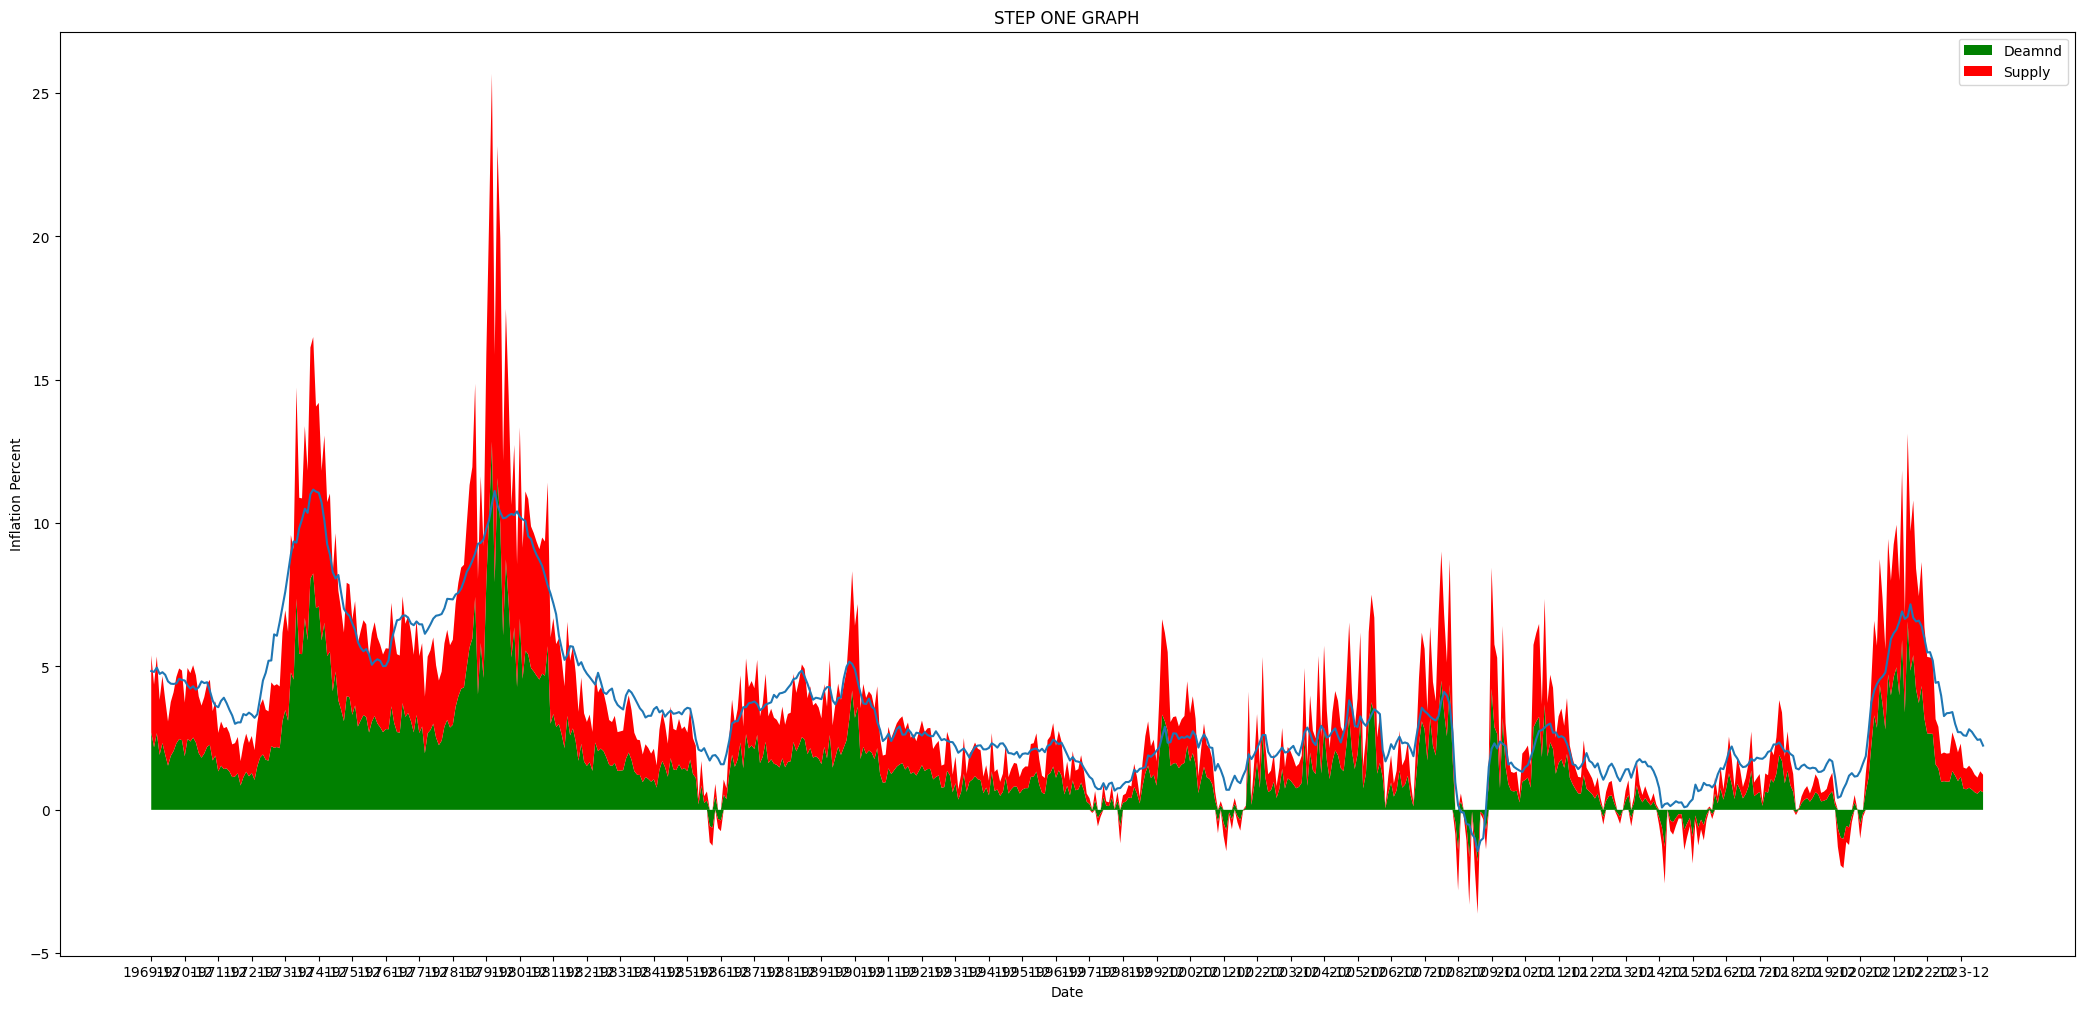

In [ ]:
inflation_df = inflation_df.iloc[:,131:]
expenditure_weights = expenditure_weights.iloc[:,131:]
Demand = Demand.iloc[:,131:]



def graph_function(CPI, expenditure_weights, Demand, inflation_df):
    demand_times_weight = np.multiply(Demand, expenditure_weights)
    demand_bar = np.multiply(demand_times_weight, inflation_df)

    one_minus_Demand = 1 - Demand
    supply_times_weight = np.multiply(one_minus_Demand, expenditure_weights)
    supply_bar = np.multiply(supply_times_weight, inflation_df)

    demand_sum = supply_bar.sum()
    supply_sum = supply_bar.sum()

    supply_inflation = pd.DataFrame(supply_sum, columns=['Supply Inflation'])
    demand_inflation = pd.DataFrame(demand_sum, columns=['Demand Inflation'])

    supply_inflation['supply_pos'] = supply_inflation['Supply Inflation'].apply(lambda x: x if x > 0 else 0)
    demand_inflation['demand_pos'] = demand_inflation['Demand Inflation'].apply(lambda x: x if x > 0 else 0)
    supply_inflation['supply_neg'] = supply_inflation['Supply Inflation'].apply(lambda x: x if x < 0 else 0)
    demand_inflation['demand_neg'] = demand_inflation['Demand Inflation'].apply(lambda x: x if x < 0 else 0)

    demand_inflation = demand_inflation.iloc[:-1]
    supply_inflation = supply_inflation.iloc[:-1]

    plt.figure(figsize=(26, 12))

    plt.stackplot(supply_inflation.index, demand_inflation['demand_pos'], supply_inflation['supply_pos'], colors= ["#008000", "#FF0000"], labels = ["Deamnd", "Supply"])
    plt.stackplot(supply_inflation.index, demand_inflation['demand_neg'], supply_inflation['supply_neg'], colors= ["#008000", "#FF0000"])
    plt.xlabel('Date')
    plt.ylabel('Inflation Percent')
    plt.title('STEP ONE GRAPH')
    plt.legend()

    x = supply_inflation.index
    y = CPI["Inflation"]

    plt.plot(x, y)  
    plt.xticks(x[::12])

    return plt


graph_function(CPI, expenditure_weights, Demand, inflation_df)


# 2. Using graph_function to replicate Shaprio Classification 

# 3. Using graph_function to implement VA and Sale Share Classification

# a)  Getting D_i_t from Emily's Old Cold -> THIS DATA IS PROBABLY NOT CORRECT AT THE COMMENT

In [ ]:
residuals_emily = pd.read_pickle(path_cleandata + '/inversions/residuals.pkl')
residuals_emily['majority_demand'] = ((residuals_emily['resid_price'] * residuals_emily['resid_quantity']) >= 0).astype(int)
residuals_emily['majority_supply'] = ((residuals_emily['resid_price'] * residuals_emily['resid_quantity']) < 0).astype(int)
residuals_emily

,date,product,resid_price,resid_quantity,resid_valueadded,resid_sales,majority_demand,majority_supply
0,1961-04-30,Accessories and parts,0.004256,0.014899,0.008914,0.014123,1,0
1,1961-04-30,Air transportation,0.014324,0.038847,0.032823,0.03019,1,0
2,1961-04-30,Alcohol in purchased meals,0.005319,-0.013163,0.010991,-0.009891,0,1
3,1961-04-30,"Amusement parks, campgrounds, and related recr...",-0.005775,0.024311,-0.004257,0.00075,0,1
4,1961-04-30,"Audio discs, tapes, vinyl, and permanent digit...",-0.003175,0.053754,-0.002723,0.044384,0,1
...,...,...,...,...,...,...,...,...
36745,2023-07-31,Water supply and sewage maintenance,-0.001661,0.000983,-0.001167,0.002722,0,1
36746,2023-07-31,Water transportation,0.020567,-0.010366,0.049007,0.009165,0,1
36747,2023-07-31,Window coverings,0.015643,-0.022738,0.060318,-0.005788,0,1
36748,2023-07-31,Wine,-0.004331,-0.001757,-0.000163,-0.003778,1,0


In [ ]:
residuals_emily = residuals_emily[residuals_emily['product'].isin(gamma_shaprio['Unnamed: 0'])]
residuals_emily

,date,product,resid_price,resid_quantity,resid_valueadded,resid_sales,majority_demand,majority_supply
0,1961-04-30,Accessories and parts,0.004256,0.014899,0.008914,0.014123,1,0
1,1961-04-30,Air transportation,0.014324,0.038847,0.032823,0.03019,1,0
3,1961-04-30,"Amusement parks, campgrounds, and related recr...",-0.005775,0.024311,-0.004257,0.00075,0,1
8,1961-04-30,Beer,-0.002585,-0.007538,-0.007012,-0.012246,1,0
9,1961-04-30,Bicycles and accessories,0.004792,-0.005089,0.008203,0.001043,0,1
...,...,...,...,...,...,...,...,...
36745,2023-07-31,Water supply and sewage maintenance,-0.001661,0.000983,-0.001167,0.002722,0,1
36746,2023-07-31,Water transportation,0.020567,-0.010366,0.049007,0.009165,0,1
36747,2023-07-31,Window coverings,0.015643,-0.022738,0.060318,-0.005788,0,1
36748,2023-07-31,Wine,-0.004331,-0.001757,-0.000163,-0.003778,1,0


In [ ]:
D = residuals_emily.pivot(index='product', columns='date', values='majority_demand')
# shaprio_products = shaprio_products.str.lstrip()
# D = D[D.index.isin(shaprio_products)]
# D.index.name = None
# D = D[D['product'].isin(shaprio_products)]
# D.to_excel("emilyresiduals.xlsx")


In [ ]:
# shaprio_products.to_excel("shaprio_products.xlsx")

# b) Calculate the Influence of D_i_t onto Prices

In [ ]:
delta_gamma = pd.read_excel(path_cleandata + "/delta.xlsx")

delta = delta_gamma.iloc[:, :-1]
delta.index.name = None
delta.set_index(delta.columns[0], inplace=True)

big_o = np.linalg.inv(np.identity(len(delta)) - delta)
big_o = pd.DataFrame(big_o, index=delta.index, columns=delta.columns)
big_o.index.name = None
big_o

,Accessories and parts,Air transportation,Alcohol in purchased meals,All other professional medical services,"Amusement parks, campgrounds, and related recreational services","Audio discs, tapes, vinyl, and permanent digital downloads",Audio equipment,Auto leasing,Bakery products,Beef and veal,...,Vegetables (fresh),Veterinary and other services for pets,Video and audio streaming and rental,"Video discs, tapes, and permanent digital downloads",Watches,Water supply and sewage maintenance,Water transportation,Window coverings,Wine,Women's and girls' clothing
Accessories and parts,1.133436,0.000243,0.001575,0.000018,0.000676,0.000021,0.020513,0.000128,0.000004,0.000156,...,0.000089,0.000051,0.001362,0.000024,4.954189e-06,0.000479,0.000067,0.000066,0.000006,0.000942
Air transportation,0.000092,1.000051,0.001214,0.000029,0.004291,0.000006,0.000039,0.000011,0.000008,0.000004,...,0.000004,0.000003,0.000345,0.000009,3.419047e-06,0.000513,0.000007,0.000001,0.000215,0.000002
Alcohol in purchased meals,0.000745,0.000200,1.002039,0.000019,0.002196,0.000385,0.000106,0.000069,0.001015,0.000762,...,0.000096,0.000127,0.001545,0.000058,8.901932e-07,0.000653,0.000024,0.000021,0.001433,0.000017
All other professional medical services,0.000820,0.000136,0.002945,1.000176,0.000444,0.000014,0.000090,0.000120,0.000007,0.000014,...,0.000011,0.000018,0.000466,0.000042,8.412009e-07,0.000247,0.000014,0.000018,0.000027,0.000071
"Amusement parks, campgrounds, and related recreational services",0.001096,0.000301,0.001873,0.000062,1.001767,0.000077,0.000147,0.000620,0.000111,0.000309,...,0.000063,0.000087,0.001378,0.000057,1.324038e-06,0.000573,0.000014,0.000060,0.000423,0.000060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Water supply and sewage maintenance,0.000466,0.000117,0.001222,0.000008,0.000365,0.000017,0.000083,0.000097,0.000003,0.000006,...,0.000014,0.000022,0.000749,0.000029,2.523920e-05,1.002347,0.000067,0.000002,0.000005,0.000005
Water transportation,0.000189,0.000082,0.000248,0.000032,0.004514,0.000012,0.000025,0.000199,0.000031,0.000016,...,0.000005,0.000005,0.000326,0.000006,6.663871e-07,0.000219,1.000009,0.000008,0.000037,0.000009
Window coverings,0.006497,0.000108,0.000580,0.000008,0.000342,0.000016,0.000352,0.000058,0.000002,0.000020,...,0.000282,0.000036,0.000991,0.000011,6.995975e-07,0.000417,0.000020,1.001666,0.000003,0.003459
Wine,0.013422,0.000394,0.002198,0.000033,0.001293,0.000027,0.000412,0.000227,0.000030,0.000082,...,0.000467,0.002786,0.001812,0.000031,3.067842e-06,0.000860,0.000582,0.000006,1.066999,0.000027


# C) ??

# D) Calculate theta_t 

In [ ]:
price_value_added = residuals_emily.pivot(index='product', columns='date', values='resid_price')
price_value_added.index.name = None
price_value_added

date,1961-04-30,1961-07-31,1961-10-31,1962-01-31,1962-04-30,1962-07-31,1962-10-31,1963-01-31,1963-04-30,1963-07-31,...,2021-04-30,2021-07-31,2021-10-31,2022-01-31,2022-04-30,2022-07-31,2022-10-31,2023-01-31,2023-04-30,2023-07-31
Accessories and parts,0.004256,-0.000314,-0.006907,-0.008427,-0.074604,0.018761,-0.010179,-0.005218,0.004537,0.006189,...,0.014854,0.004928,0.019939,0.001348,0.007456,0.004339,0.009142,-0.009369,-0.008157,-0.029102
Air transportation,0.014324,0.001264,0.003436,0.014548,0.008705,-0.019327,-0.024204,-0.026055,-0.015016,-0.028723,...,0.007753,0.002277,0.019436,-0.003317,0.005973,-0.025345,0.041567,0.015414,0.001628,0.000150
"Amusement parks, campgrounds, and related recreational services",-0.005775,-0.004706,-0.000405,-0.008815,-0.002285,0.001898,-0.001244,-0.003609,0.000322,-0.000679,...,0.007122,0.003544,0.001743,-0.000305,-0.002207,0.001075,0.013101,0.000762,-0.013114,0.003221
Beer,-0.002585,0.000724,-0.001224,-0.004006,-0.002356,-0.001395,-0.001073,-0.003704,-0.000937,0.000201,...,-0.004069,0.006865,-0.012745,0.008551,0.010178,0.003555,0.011474,-0.002653,-0.007200,-0.003832
Bicycles and accessories,0.004792,0.000813,0.004245,-0.002576,-0.005234,-0.003597,-0.011018,-0.006194,-0.001914,0.003081,...,0.012550,0.010858,0.014501,-0.006629,-0.016407,-0.012648,0.001548,0.003543,-0.020193,-0.000251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Water supply and sewage maintenance,-0.002015,-0.003171,-0.001701,-0.004561,0.003514,-0.000513,0.000778,0.000732,-0.000167,-0.003804,...,-0.000026,0.000338,0.000745,0.007321,-0.004142,0.004211,-0.002845,0.006413,-0.002029,-0.001661
Water transportation,-0.028621,0.015298,-0.040583,0.036952,0.012817,-0.030939,-0.004495,0.007703,0.033636,-0.011815,...,0.002428,-0.000676,-0.002086,0.002397,-0.010054,-0.003739,0.007041,-0.005264,-0.003329,0.020567
Window coverings,-0.001382,-0.001726,0.007617,-0.009376,-0.012637,-0.014403,0.008025,0.005124,0.008264,-0.016028,...,0.005135,0.014011,0.005983,-0.014162,0.021194,0.016865,-0.032431,0.034117,-0.033004,0.015643
Wine,-0.001240,-0.003648,-0.002268,-0.003163,-0.004719,-0.001236,-0.003999,0.000147,0.002726,-0.002989,...,0.003534,-0.002851,-0.004535,0.008811,0.004651,0.002425,-0.001609,0.001235,-0.002628,-0.004331


In [ ]:
big_o = big_o.loc[big_o.index.intersection(price_value_added.index), big_o.columns.intersection(price_value_added.index)]
big_o

,Accessories and parts,Air transportation,"Amusement parks, campgrounds, and related recreational services",Beer,Bicycles and accessories,Carpets and other floor coverings,Casino gambling,Children's and infants' clothing,"Clocks, lamps, lighting fixtures, and other household decorative items",Clothing materials,...,Therapeutic medical equipment,Tires,"Tools, hardware, and supplies",Veterinary and other services for pets,Watches,Water supply and sewage maintenance,Water transportation,Window coverings,Wine,Women's and girls' clothing
Accessories and parts,1.133436,0.000243,0.000676,0.000012,1.480338e-06,0.004300,4.202270e-08,0.000128,0.011228,0.002528,...,0.000086,0.000076,0.019880,0.000051,4.954189e-06,0.000479,0.000067,0.000066,0.000006,0.000942
Air transportation,0.000092,1.000051,0.004291,0.000102,2.224108e-06,0.000019,3.711770e-08,0.000002,0.000064,0.000004,...,0.000003,0.000127,0.000079,0.000003,3.419047e-06,0.000513,0.000007,0.000001,0.000215,0.000002
"Amusement parks, campgrounds, and related recreational services",0.001096,0.000301,1.001767,0.001715,1.245106e-06,0.000181,5.444484e-08,0.000035,0.001094,0.000115,...,0.000089,0.000054,0.000857,0.000087,1.324038e-06,0.000573,0.000014,0.000060,0.000423,0.000060
Beer,0.023055,0.000293,0.001197,1.100789,1.392864e-06,0.000514,9.482926e-08,0.000150,0.075456,0.000156,...,0.000047,0.000074,0.004818,0.000854,1.183730e-05,0.001331,0.000367,0.000008,0.000028,0.000049
Bicycles and accessories,0.001228,0.000097,0.000311,0.000003,1.061203e+00,0.000257,2.110053e-08,0.000111,0.001763,0.000376,...,0.000311,0.002373,0.002417,0.000008,6.019737e-07,0.000252,0.000038,0.000101,0.000002,0.000117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Water supply and sewage maintenance,0.000466,0.000117,0.000365,0.000007,3.809769e-07,0.000178,1.556640e-05,0.000004,0.001978,0.000012,...,0.000214,0.000007,0.000610,0.000022,2.523920e-05,1.002347,0.000067,0.000002,0.000005,0.000005
Water transportation,0.000189,0.000082,0.004514,0.000040,1.783770e-07,0.000025,1.871208e-08,0.000009,0.003047,0.000015,...,0.000005,0.000002,0.000179,0.000005,6.663871e-07,0.000219,1.000009,0.000008,0.000037,0.000009
Window coverings,0.006497,0.000108,0.000342,0.000007,5.828173e-07,0.004196,3.546003e-08,0.000166,0.000823,0.015064,...,0.000040,0.000031,0.008688,0.000036,6.995975e-07,0.000417,0.000020,1.001666,0.000003,0.003459
Wine,0.013422,0.000394,0.001293,0.000147,1.722882e-06,0.000225,6.652813e-08,0.000076,0.011606,0.000082,...,0.000040,0.000093,0.001637,0.002786,3.067842e-06,0.000860,0.000582,0.000006,1.066999,0.000027


In [ ]:
# Dictionary that stores all the theta for each time period
all_thetas = {}
k = {}
lam = {}

for series_name, series in price_value_added.items():
    """This function performs the steps outlined in 3d) and 3e). It loops through P_VA for all time periods 
    and appends the resutling theta in all_thetas. Columns sums are saved in dictionary k. 
    """
    ones = np.ones(len(series)).T
    theta = np.kron(series, ones)
    dataframe = pd.DataFrame(theta.reshape(-1, len(price_value_added.index)))
    dataframe = dataframe.set_index(price_value_added.index)
    dataframe.columns = price_value_added.index
    theta_final = big_o.dot(dataframe)
    column_sum = theta_final
    all_thetas[f"{series_name}"] = theta_final.copy()

    # Calculates and stores column sums 
    k[f"{series_name}"] = theta_final.sum().to_frame().T.set_axis([series_name]).copy()

    # Calculates Influence lambda and stores them 
    lam[f"{series_name}"] = theta_final.div(theta_final.sum()).copy()

# g) + h) Calculate input D 

In [ ]:
residuals_emily = pd.read_pickle(path_cleandata + '/inversions/residuals.pkl')
residuals_emily['majority_demand'] = ((residuals_emily['resid_price'] * residuals_emily['resid_quantity']) >= 0).astype(int)
residuals_emily['majority_supply'] = ((residuals_emily['resid_price'] * residuals_emily['resid_quantity']) < 0).astype(int)
D_hat = residuals_emily.pivot(index='product', columns='date', values='majority_demand')
D_hat.index.name = None
D_hat

date,1961-04-30,1961-07-31,1961-10-31,1962-01-31,1962-04-30,1962-07-31,1962-10-31,1963-01-31,1963-04-30,1963-07-31,...,2021-04-30,2021-07-31,2021-10-31,2022-01-31,2022-04-30,2022-07-31,2022-10-31,2023-01-31,2023-04-30,2023-07-31
Accessories and parts,1,0,0,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
Air transportation,1,1,1,1,1,1,0,0,0,0,...,1,1,1,0,1,0,1,0,1,1
Alcohol in purchased meals,0,0,0,0,0,0,0,1,0,1,...,1,1,1,1,1,0,1,0,0,0
"Amusement parks, campgrounds, and related recreational services",0,0,0,0,0,0,0,0,1,0,...,1,1,1,0,0,1,1,1,1,0
"Audio discs, tapes, vinyl, and permanent digital downloads",0,0,1,1,1,0,1,1,0,0,...,0,1,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Water supply and sewage maintenance,0,1,0,0,0,0,1,1,0,0,...,0,1,1,1,0,1,1,1,1,0
Water transportation,0,0,0,0,0,1,1,1,0,0,...,0,0,0,0,1,1,0,1,1,0
Window coverings,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
Wine,1,0,0,0,1,0,1,0,1,0,...,0,1,0,0,0,0,1,0,1,1


In [ ]:
# Will need to change these product filtering stuff eventually
D_hat = D_hat[D_hat.index.isin(price_value_added.index)]

In [ ]:
D_list = []

"""This loop calculates the input D one column at a time as described in 3g)"""
for (lam_key, lam_val), (D_key, D_val) in zip(lam.items(), D_hat.items()):
    """Just checking to make sure the dates match"""
    if lam_key == str(D_key):
        D_t = lam_val.dot(D_val)
        D_t = D_t.to_frame(name=lam_key).copy()
        D_list.append(D_t)

    else: 
        print(lam_key)
        print(D_key)
        raise IndexError


D_matrix = pd.concat(D_list, axis=1)

In [ ]:
D_matrix

,1961-04-30 00:00:00,1961-07-31 00:00:00,1961-10-31 00:00:00,1962-01-31 00:00:00,1962-04-30 00:00:00,1962-07-31 00:00:00,1962-10-31 00:00:00,1963-01-31 00:00:00,1963-04-30 00:00:00,1963-07-31 00:00:00,...,2021-04-30 00:00:00,2021-07-31 00:00:00,2021-10-31 00:00:00,2022-01-31 00:00:00,2022-04-30 00:00:00,2022-07-31 00:00:00,2022-10-31 00:00:00,2023-01-31 00:00:00,2023-04-30 00:00:00,2023-07-31 00:00:00
Accessories and parts,-0.462074,0.348531,1.214840,1.940161,10.833964,-4.796287,1.792914,0.675974,-1.159799,-4.549584,...,2.240385,0.414012,0.893731,0.131032,0.418692,-0.997824,-11.330027,1.110375,1.607041,3.417486
Air transportation,-1.422669,-0.706728,-0.512814,-2.901201,-1.095972,4.298047,3.596258,2.730815,3.901732,18.419077,...,0.913218,0.170243,0.754708,-0.075224,0.297393,5.585092,-54.907976,-1.406124,-0.218791,-0.076784
"Amusement parks, campgrounds, and related recreational services",0.609929,2.539212,0.049506,1.860339,0.298560,-0.436409,0.244439,0.400528,-0.033918,0.476782,...,0.942951,0.249489,0.068038,0.009859,-0.081881,-0.173995,-16.127736,-0.000815,1.939519,-0.295564
Beer,0.329039,-0.209394,0.195510,0.953829,0.687096,-0.012385,0.323681,0.650717,0.612010,-0.424845,...,-0.369564,0.562976,-0.387076,0.540559,0.563031,-0.604916,-10.148312,0.534865,1.337056,0.654939
Bicycles and accessories,-0.532909,-0.623250,-0.580520,0.589461,0.751885,0.842964,1.899532,0.717026,0.548718,-2.174324,...,1.669040,0.744238,0.579379,-0.287162,-0.858796,2.917671,0.389415,-0.790617,3.268714,0.080700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Water supply and sewage maintenance,0.233909,1.716054,0.267530,0.986183,-0.438275,0.125393,-0.086252,-0.041822,0.117384,2.494869,...,0.000752,0.053415,0.050848,0.326131,-0.158105,-0.743659,4.125466,-0.540535,0.308876,0.151447
Water transportation,2.950126,-8.079624,6.353796,-7.412670,-1.626959,6.820712,0.673845,-0.769373,-8.547047,7.554719,...,0.291465,-0.027654,-0.059292,0.120262,-0.435449,0.913525,-9.351635,0.543065,0.511267,-2.108499
Window coverings,0.174281,1.009938,-1.179109,2.049806,1.691656,3.140925,-1.134293,-0.490483,-2.035122,10.382230,...,0.859861,0.889879,0.252889,-0.535292,1.043553,-3.813094,43.595155,-3.129522,4.869493,-1.528659
Wine,0.327800,2.851543,0.404347,0.645715,0.858167,0.093818,0.653366,0.286241,-0.542865,2.449039,...,0.730903,-0.203999,0.001178,0.675152,0.329395,-0.731774,-3.484691,0.811308,0.172344,0.392464
